In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob

%matplotlib inline

In [2]:
def show_image(img, cmap=None, save_as=None):
    my_dpi=96
    height=540
    width=960
    
    fig = plt.figure(figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi, frameon=False)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    plt.imshow(img, cmap)
    
    if save_as != None:
        plt.savefig(save_as)

In [14]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

def warp_lane_image(img, mtx, dist):
    
    undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    img_size = img.shape

    src = np.float32(
        [[(img_size[1] / 2) - 470, img_size[0] - 60],
        [(img_size[1] / 2) - 88, img_size[0] - 255],
        [(img_size[1] / 2) + 88, img_size[0] - 255],
        [(img_size[1] / 2) + 470, img_size[0] - 60]])
    
    dst = np.float32(
        [[(img_size[1] / 2) - 350, img_size[0]],
        [(img_size[1] / 2) - 350, 0],
        [(img_size[1] / 2) + 350, 0],
        [(img_size[1] / 2) + 350, img_size[0]]])
        
    warped = warper(undistort_img, src, dst)
    
    return warped

def pipeline(img, s_thresh=(170, 220), sx_thresh=(20, 100)):
    # return img
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

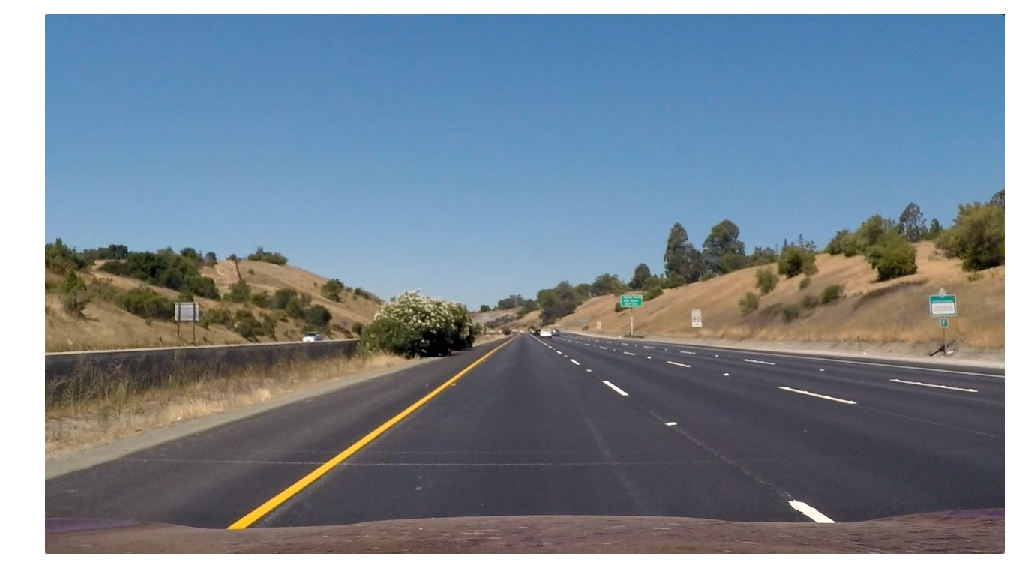

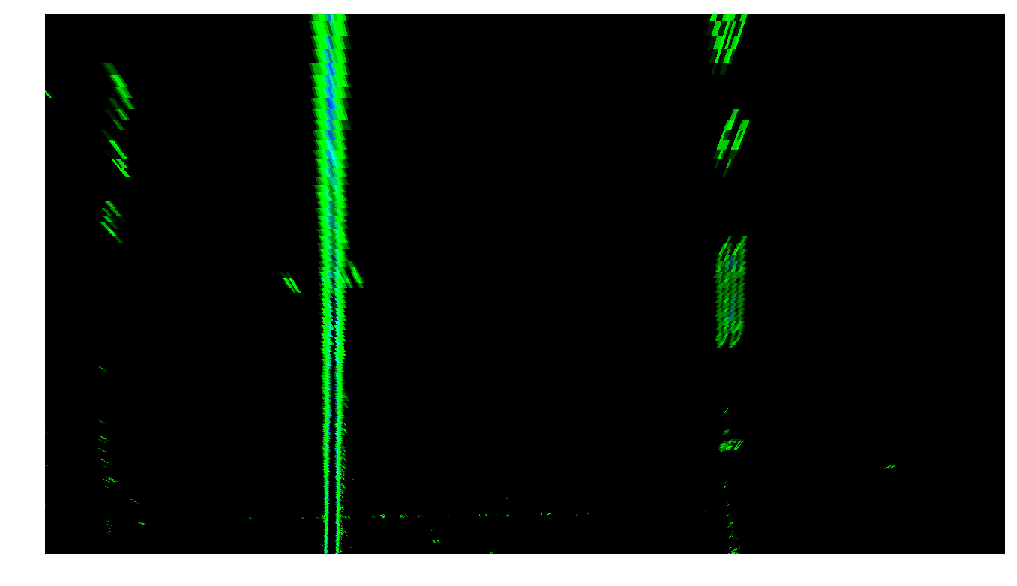

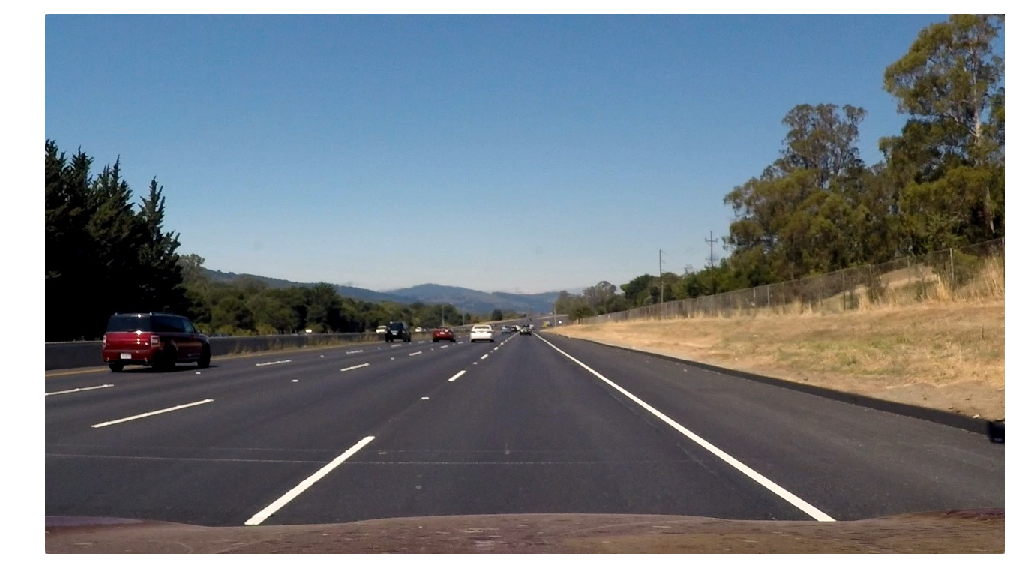

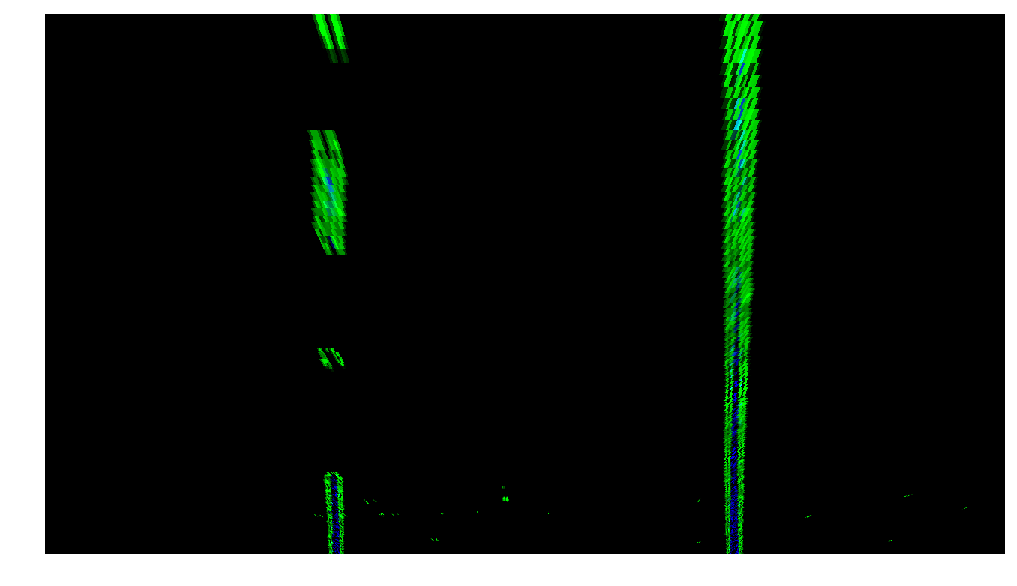

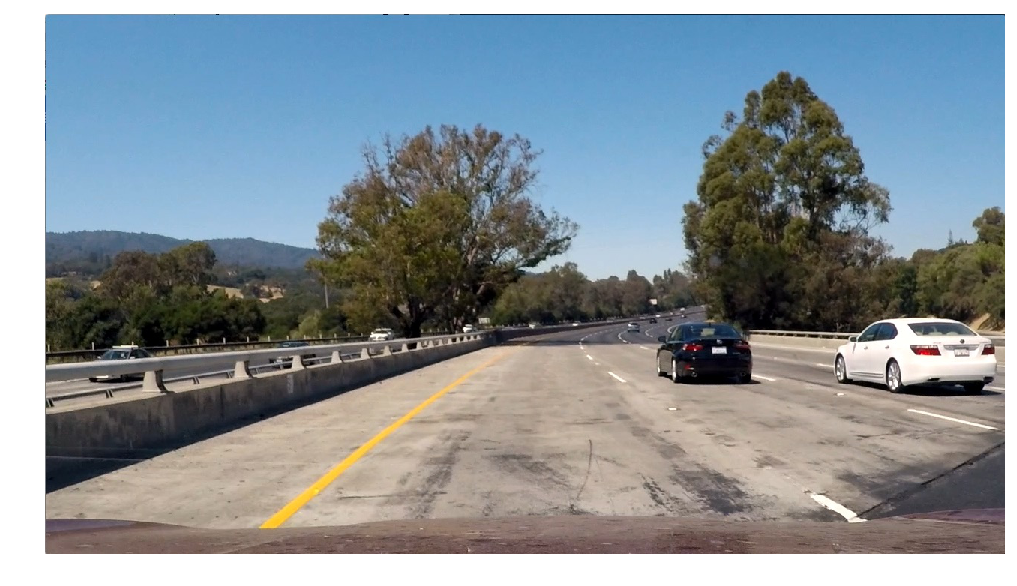

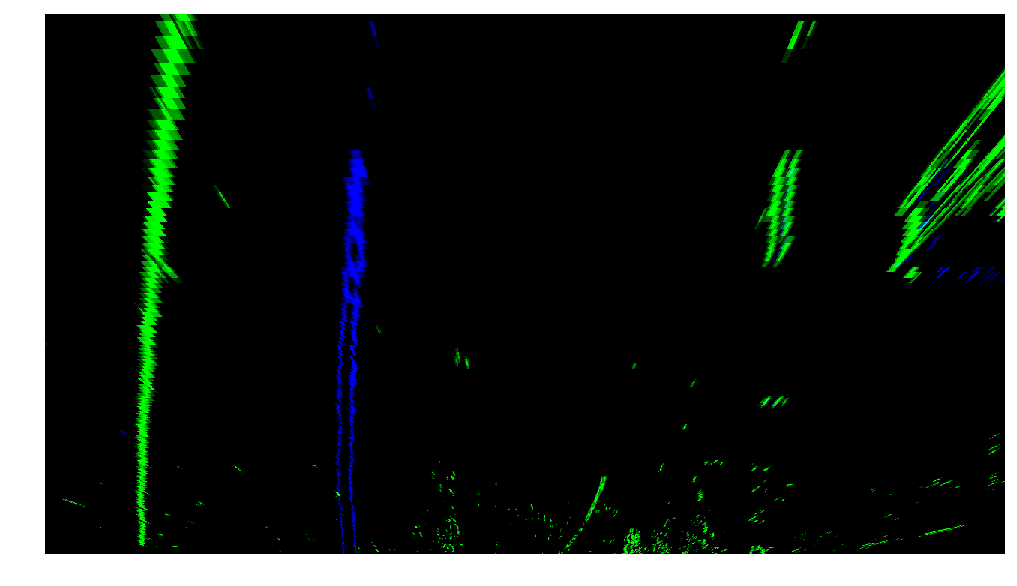

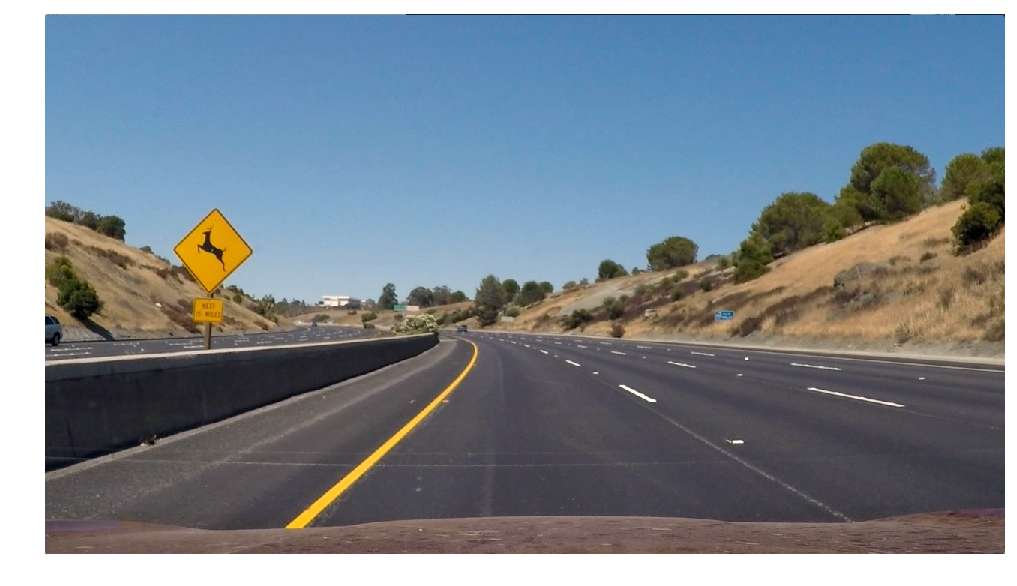

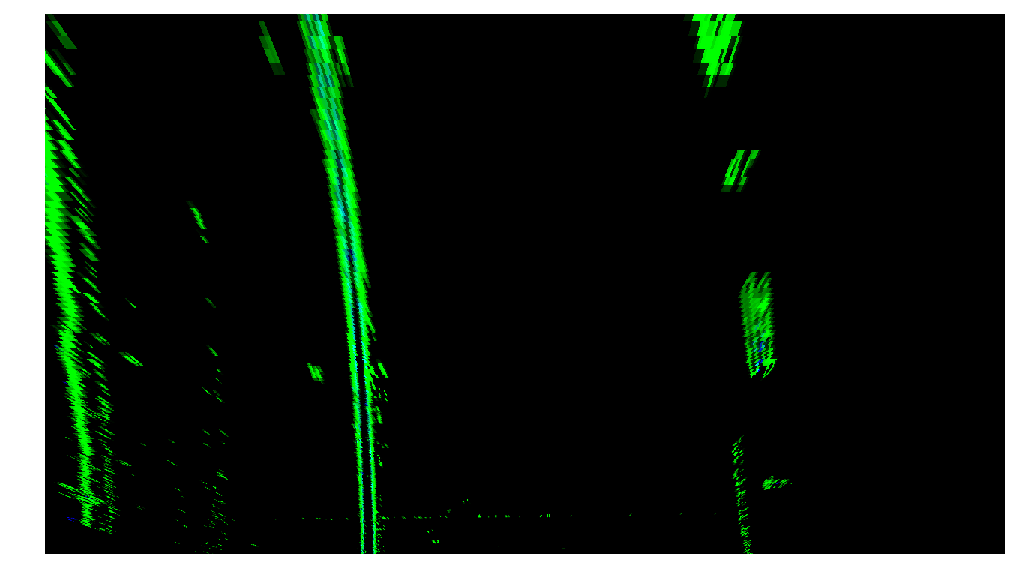

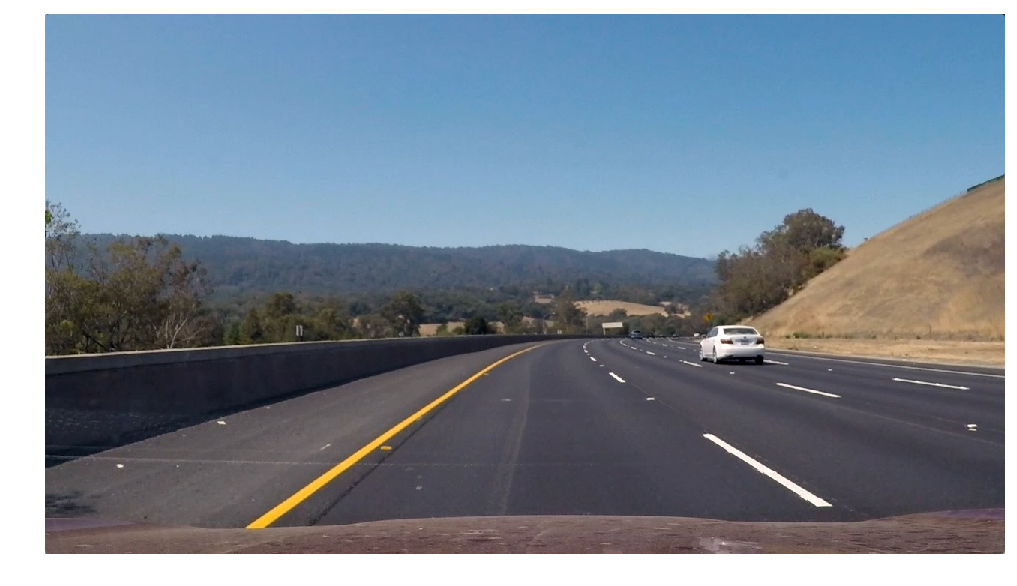

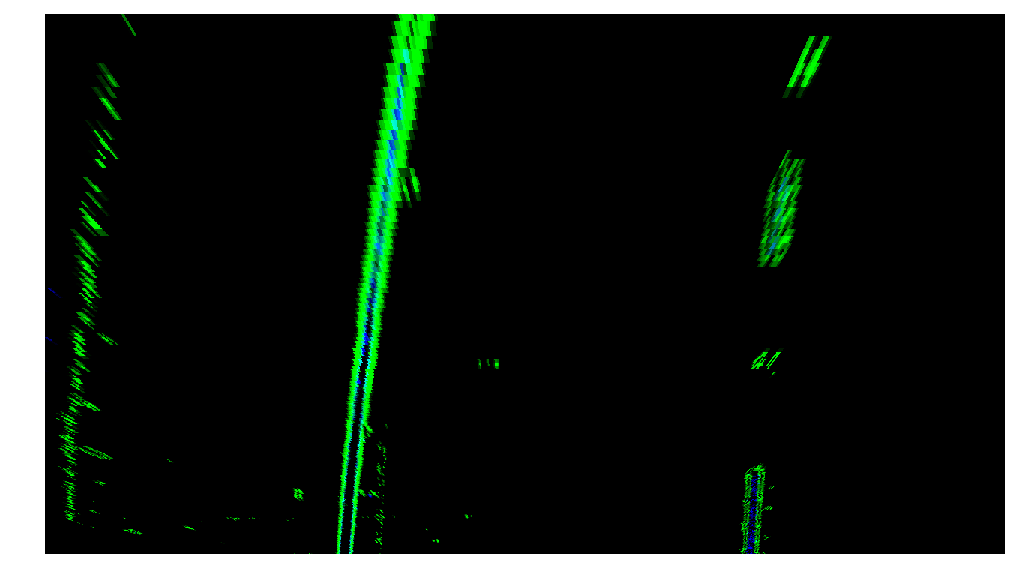

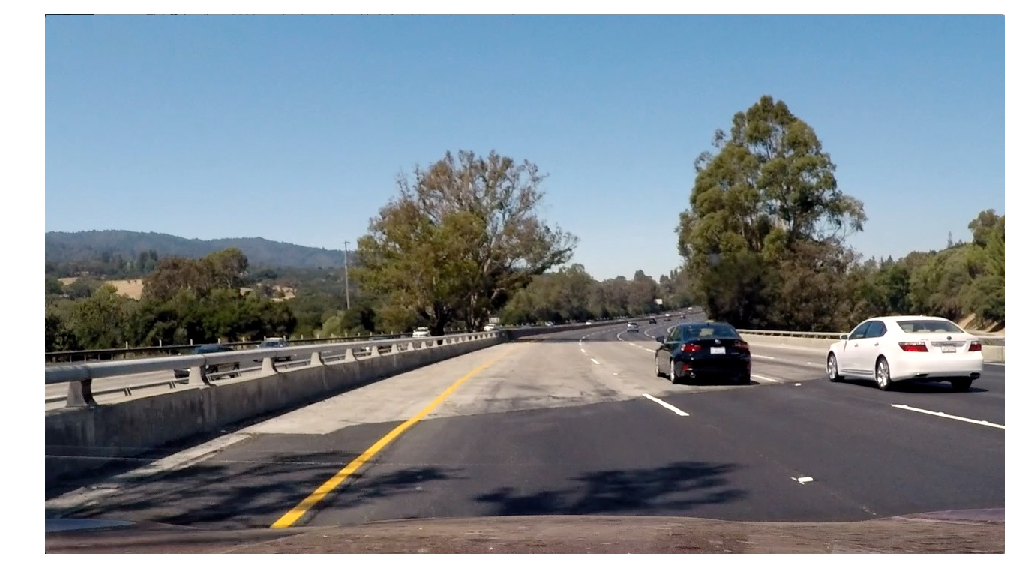

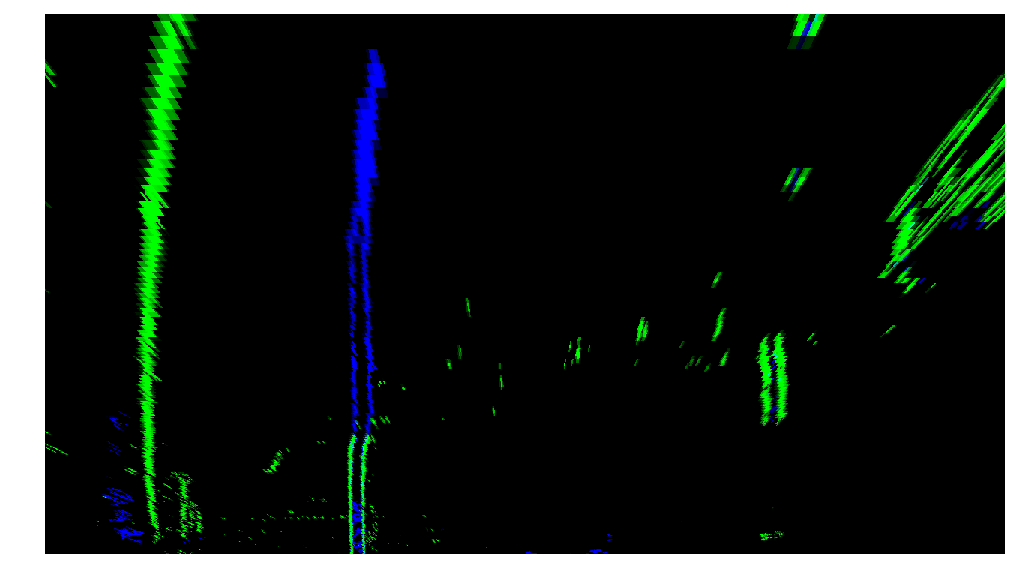

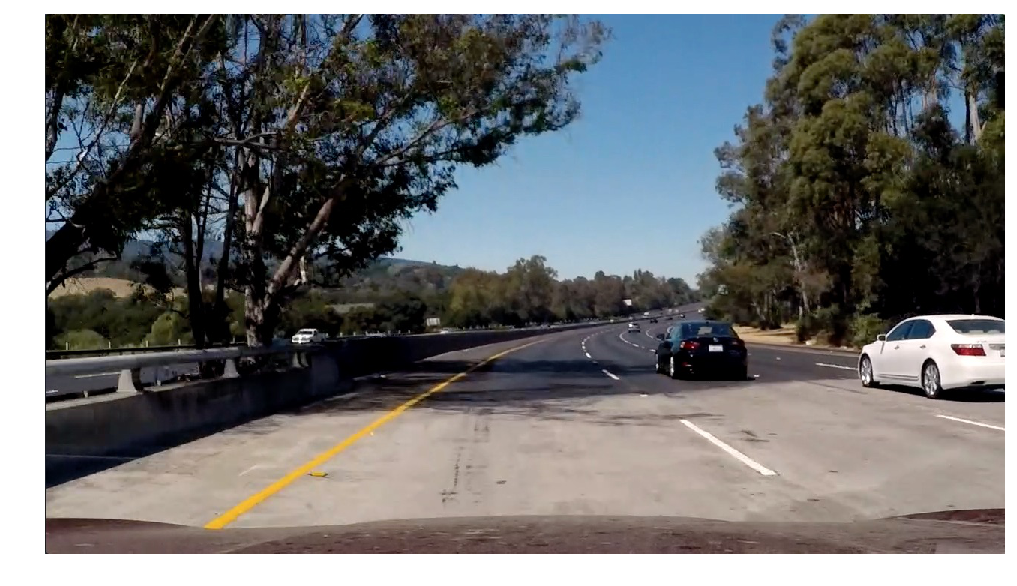

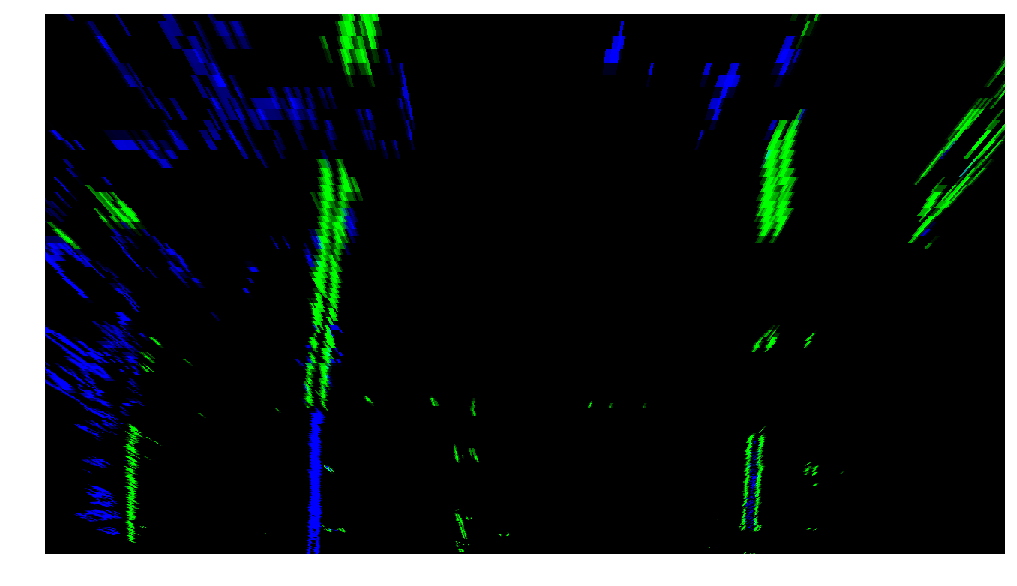

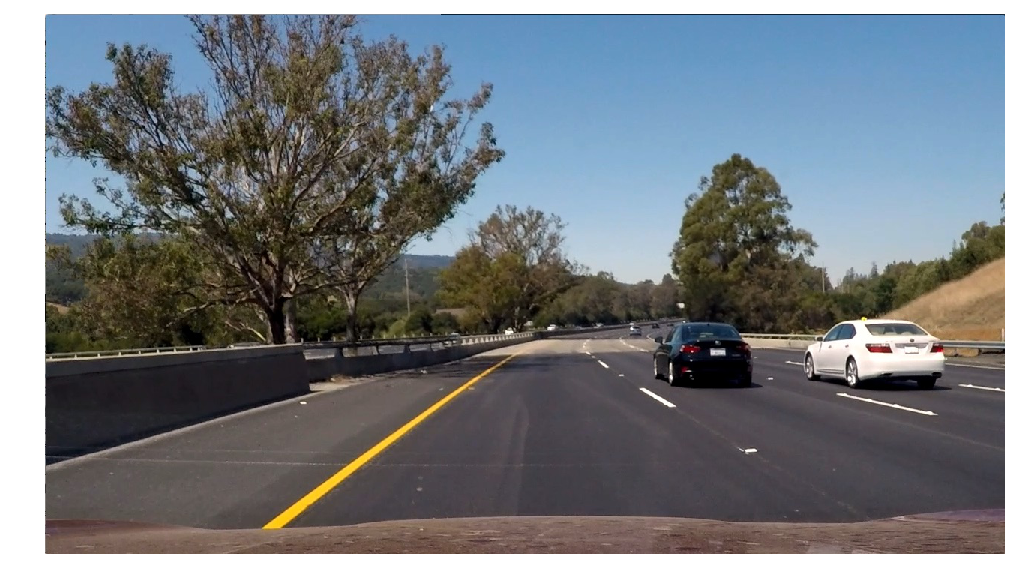

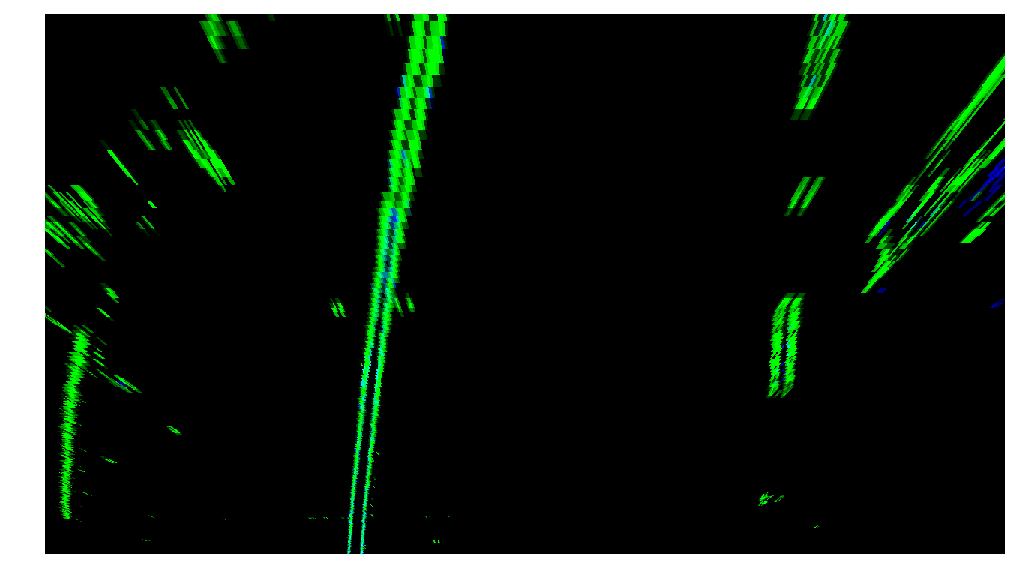

In [16]:
dist_pickle = pickle.load( open( "calibration_pickle.p", "rb" ) )
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']
for file_name in glob.glob('test_images/*.jpg'):
#for file_name in ['test_images/straight_lines2.jpg']:
    img = cv2.imread(file_name)        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
    show_image(img)
    
    bitmap = pipeline(img)    
    warped_img = warp_lane_image(bitmap, mtx, dist)            
    show_image(warped_img)

In [ ]:
from moviepy.editor import VideoFileClip    

def process_video(input_path, output_path):
    
    dist_pickle = pickle.load( open( "calibration_pickle.p", "rb" ) )
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    
    def image_pipeline(img):
        return warp_lane_image(img, mtx, dist) 
    
    in_clip = VideoFileClip(input_path)
    out_clip = in_clip.fl_image(image_pipeline) 
    %time out_clip.write_videofile(output_path, audio=False)

In [ ]:
process_video('harder_challenge_video.mp4', 'test_videos_output/harder_challenge_video.mp4')
